# **Inversión 1D con datos reales (Mesa de Los Santos)**
**Elaborado por:** \
Ivan Camilo Caballero Jaimes 2210623\
Johan Enrique Páez Romero 2210631\
Semillero de Investigación en Geofísica Aplicada y Computacional - **SIGAC**

## Liberías 

In [1]:
import numpy as np
from copy import deepcopy
from pathlib import Path
import pandas as pd
from mtpy import MT, MTCollection
import inspect
from mtpy.core.z import Z
import numpy as np
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit, 
    regularization,
    optimization,
    inverse_problem,
    inversion, 
    directives,
    utils,
)

## Visualizar datos en formato .edi

En el contexto de los estudios magnetotelúricos (MT), los archivos .edi (Electrical Data Interchange) son un formato estándar para 
almacenar y compartir datos. Estos incluyen información sobre la ubicación del sitio, parámetros de adquisición y **Tensores de impedancia**. En esta sección con ayuda de la librería MTpy y el modulo Z vamos a visualizar y explorar el contenido de los datos en formato .edi 

In [2]:
mc = MTCollection()
mc.open_collection(
    filename=Path().cwd().parent.parent.joinpath("Magnetotelurica")
)

In [3]:
bb_edi_path = Path().cwd().parent.parent.joinpath("Magnetotelurica", "Repositorio") #Debes ajustar esta ruta según dónde estén tus archivos
for edi_filename in mc.make_file_list(bb_edi_path, file_types=["edi"]):
    mt_object = MT(edi_filename)
    mt_object.read()

    # update the survey id
    mt_object.survey_metadata.id = "MC"
    mc.add_tf(mt_object)

In [4]:
mc.dataframe

,station,survey,latitude,longitude,elevation,tf_id,units,has_impedance,has_tipper,has_covariance,period_min,period_max,hdf5_reference,station_hdf5_reference
0,P,MC,6.963111,-73.048167,958.253,P,none,True,True,True,0.0001,364.088893,<HDF5 object reference>,<HDF5 object reference>


In [5]:
tf = mc.get_tf("P", survey="MC") #Extraemos el archivo ubicado anteriormente y lo guardamos en una variable
print(tf)
type(tf)

Station: P
--------------------------------------------------
	Survey:            MC
	Project:           None
	Acquired by:       GIDCO SAS
	Acquired date:     2022-11-05
	Latitude:          6.963
	Longitude:         -73.048
	Elevation:         958.253
	Declination:   
		Value:     0.0
		Model:     WMM
	Coordinate System: geographic
	Impedance:         True
	Tipper:            True
	N Periods:     88
	Period Range:
		Min:   1.00000E-04 s
		Max:   3.64089E+02 s
	Frequency Range:
		Min:   2.74658E-03 Hz
		Max:   1.00000E+04 Hz


mtpy.core.mt.MT

In [29]:
tf.Z.res_error_det.mean()#El modulo Z nos permitirá conocer los elementos del Tensor de impendacia

7790.898250862743

In [31]:
tf.Z.resistivity_error.mean()

4245.640209159279

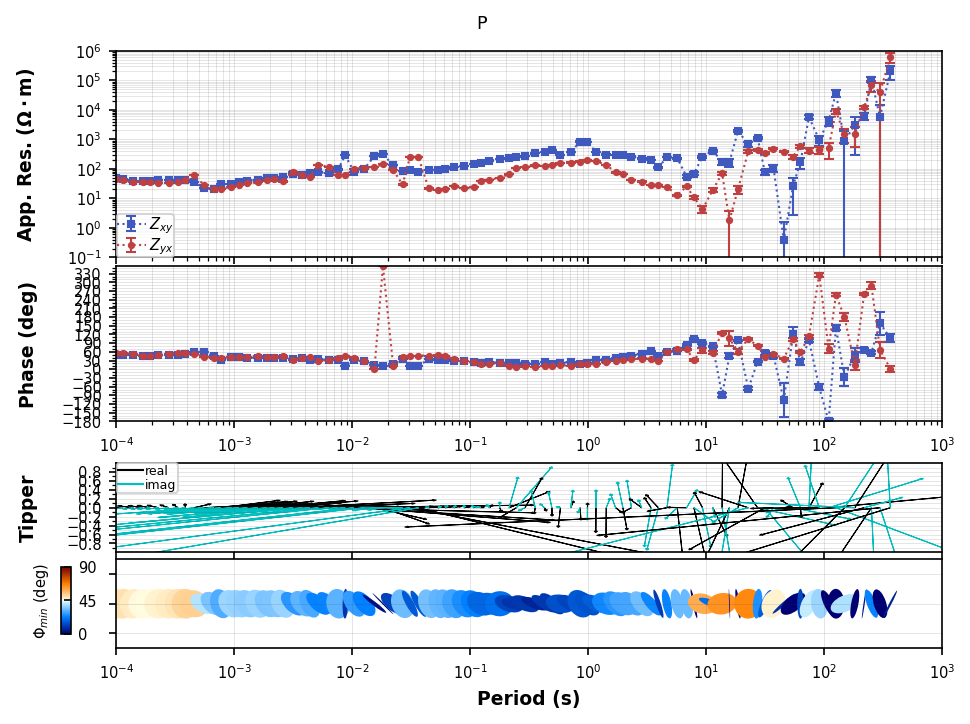

In [7]:
plot_response = tf.plot_mt_response() # vemos la respuesta de los datos

Notese que a partir de 10S en el eje X los datos tiene demasiada dispersión en el eje Y

## Extraer y filtrar datos para la inversión 

### Explicación paso a paso

Podemos extraer los datos de frecuencias, resistividad aparente y fase para luego almacenarlos en un array de números complejos.\
Es importante constatar de que todos tengan la misma cantidad de datos antes de unirlos.

In [8]:
frecuencias=np.array(tf.Z.frequency)
print(frecuencias)
len(frecuencias)

[1.000000e+04 8.800000e+03 7.200000e+03 6.000000e+03 5.200000e+03
 4.400000e+03 3.600000e+03 3.000000e+03 2.600000e+03 2.200000e+03
 1.800000e+03 1.500000e+03 1.300000e+03 1.058824e+03 9.176471e+02
 7.764706e+02 6.352941e+02 5.294118e+02 4.588235e+02 3.882353e+02
 3.176471e+02 2.647059e+02 2.294118e+02 1.941176e+02 1.588235e+02
 1.323529e+02 1.147059e+02 9.705882e+01 7.941176e+01 6.500000e+01
 5.500000e+01 4.500000e+01 3.750000e+01 3.250000e+01 2.750000e+01
 2.250000e+01 1.875000e+01 1.625000e+01 1.375000e+01 1.125000e+01
 9.375000e+00 8.125000e+00 6.875000e+00 5.625000e+00 4.687500e+00
 4.062500e+00 3.437500e+00 2.812500e+00 2.343750e+00 2.031250e+00
 1.718750e+00 1.406250e+00 1.171875e+00 1.015625e+00 8.593750e-01
 7.031250e-01 5.859375e-01 5.078125e-01 4.296875e-01 3.515625e-01
 2.929688e-01 2.539063e-01 2.148438e-01 1.757813e-01 1.464844e-01
 1.269531e-01 1.074219e-01 8.789063e-02 7.324219e-02 6.347656e-02
 5.371094e-02 4.394531e-02 3.662109e-02 3.173828e-02 2.685547e-02
 2.197266e

88

In [9]:
rho_app=np.array(tf.Z.res_det)
print(rho_app)
len(rho_app)

[4.72632775e+01 4.30039185e+01 3.69709626e+01 3.78365651e+01
 3.78526263e+01 3.73443914e+01 3.77934229e+01 3.93476128e+01
 4.23204312e+01 4.71428955e+01 2.48807545e+01 2.00659925e+01
 2.45871021e+01 2.71050130e+01 3.11044940e+01 3.57849718e+01
 3.86867407e+01 4.44354955e+01 4.63763802e+01 4.39145091e+01
 7.04350639e+01 5.98568701e+01 5.99867297e+01 9.85257475e+01
 9.01913328e+01 7.60120524e+01 1.28905879e+02 8.93214152e+01
 1.01198664e+02 1.68637330e+02 2.05902358e+02 1.02662992e+02
 4.97541693e+01 1.62519465e+02 1.51817055e+02 4.33066197e+01
 4.15508143e+01 4.35364205e+01 5.22141299e+01 5.08689116e+01
 5.67692473e+01 7.77484136e+01 8.78894943e+01 1.03650337e+02
 1.18925884e+02 1.62468156e+02 1.71998528e+02 2.06424170e+02
 2.08902698e+02 2.38645226e+02 2.10796357e+02 2.41183259e+02
 3.84065396e+02 3.86129951e+02 2.57153607e+02 2.03691993e+02
 1.45442794e+02 1.41224013e+02 9.83408932e+01 8.44593689e+01
 7.21131427e+01 5.18029082e+01 7.19067465e+01 4.50355572e+01
 2.97307655e+01 2.278353

88

In [10]:
phase=np.array(tf.Z.phase_det)
print(phase)
len(phase)

[ 52.66078918  53.23439104  50.97900738  46.87032618  46.41768914
  48.29482109  50.46644449  52.35373506  54.48175163  56.59792567
  52.84516971  44.34790063  36.5390174   42.64308671  42.21580092
  41.70480067  42.9213945   41.79053986  41.48805104  44.17830116
  37.06076485  40.6251289   39.49010112  35.29448805  35.75455728
  35.72309702  28.04444915  38.12530888  32.07576731   6.3712791
   2.37028762  13.51057553  39.08455079  38.24545231  39.61778742
  41.91132751  42.06055933  40.08126427  33.07629752  29.34238782
  26.56918064  21.83505989  21.48777017  21.62783752  16.72379492
  15.54224026  15.26981047  12.49256275  18.54383637  16.73456305
  18.67674868  18.56350218  17.86742525  19.48378979  25.33434184
  29.09520614  34.12906689  36.70253929  40.73001156  47.01669428
  46.21830678  32.89203847  58.75702313  62.55964854  72.85660822
  66.04545132  75.10242605  52.08769985  13.24077251  53.61901818
  71.8238605   21.82541326  53.94487763  38.7553305   56.78297606
 -38.499852

88

### Extración de datos

En esta sección extraemos los datos y guardamos en una variable de la forma (rho_app,phase) asociada a cada frecuencia 

In [38]:
Error_rho=tf.Z.res_error_xy.copy()
Error_phase=tf.Z.phase_error_xy.copy()
print("El error relativo de la resistividad es:","\n", Error_rho.mean(), "Su longitud es:", len(Error_rho),"\n",
      "El error de la fase es:",Error_phase.mean(), "La cantidad de datos es:", len(Error_phase))

El error relativo de la resistividad es: 
 1651.0280411838182 Su longitud es: 88 
 El error de la fase es: 3.508799473779723 La cantidad de datos es: 88


In [39]:
Errores=pd.DataFrame({'error_rho':Error_rho, 'error_fase':Error_phase})
print(Errores.head())

   error_rho  error_fase
0   0.047565    0.028085
1   0.033517    0.021129
2   0.030481    0.022514
3   0.027304    0.020161
4   0.024209    0.017364


In [41]:
Errores=Errores.iloc[:52]
print(Errores.tail())

    error_rho  error_fase
47   1.303808    0.109638
48   1.623935    0.127771
49   1.777551    0.121599
50   1.213242    0.119544
51   1.768874    0.140801


In [44]:
Error_rho=Errores['error_rho'].values
Error_phase=Errores['error_fase'].values
print("Error_rho:",Error_rho.mean(),"\n",
      "Error_fase:",Error_phase.mean())

Error_rho: 0.428992279151723 
 Error_fase: 0.0808494933460348


Dado que estos errores son sobre el total de datos es necesario calcular los errores solamente para el intervalo de datos que vamos a invertir.

In [11]:
frecuencias = np.array(tf.Z.frequency)  
rho_app = np.array(tf.Z.res_xy)         
phase = np.array(tf.Z.phase_xy)          

# Creamos el dobs y alternamos los datos en real (rho_app) y imaginario (Phase)
dobs = np.empty((0,))  
for r, p in zip(rho_app, phase):
    dobs = np.concatenate((dobs, [r, p]))

print("Datos observados:","\n" ,dobs, len(dobs), type(dobs)) #Imprimimos los datos, corroborando la cantidad 
                                                                  #Podemos corroborar la alternancia R,i con la sección anterior

Datos observados: 
 [ 4.85170790e+01  4.91133521e+01  4.54439091e+01  5.08500645e+01
  3.87861237e+01  4.91813589e+01  3.87980345e+01  4.65810541e+01
  3.99397616e+01  4.66431348e+01  4.07530390e+01  4.76366725e+01
  4.14371153e+01  4.84283171e+01  4.17166657e+01  4.98444089e+01
  4.08302546e+01  5.26018041e+01  3.56562399e+01  5.88822029e+01
  2.20321864e+01  6.10544647e+01  2.07670385e+01  4.54751794e+01
  2.96255444e+01  3.13118207e+01  3.13552479e+01  4.13590317e+01
  3.61521635e+01  4.06469705e+01  4.02131870e+01  3.98533910e+01
  4.34372590e+01  4.02618238e+01  4.92818210e+01  3.90901173e+01
  5.05756953e+01  3.89997259e+01  5.21675509e+01  4.01333198e+01
  6.51746173e+01  3.60320811e+01  6.03340814e+01  3.85275938e+01
  6.96796378e+01  3.25427207e+01  7.54034436e+01  3.40442568e+01
  7.28558454e+01  3.27557737e+01  9.53153161e+01  3.16472895e+01
  2.88456297e+02  9.91781578e+00  8.03648870e+01  3.28048863e+01
  9.92751226e+01  2.93640041e+01  2.67287089e+02  1.43472960e+01
  3.1

### Filtrado rápido de datos y skin depth

Cómo se observó en la sección *Visualizar datos en formato edi.* los datos presentan demasiado ruido a partir de 10s de periodo ó 1Hz. \
Por lo tanto, se hace necesario filtrar y usar unicamente el rango de datos sin ruido para la inversión.

In [12]:
#Para ello primero creamos un dataframe con 3 columnas que contengan los datos de frecuencia, rho_app y phase
df=pd.DataFrame({'Frecuencias': frecuencias, 'Resistividad aparente': rho_app, 'Fase': phase})
print(df.tail(40))

    Frecuencias  Resistividad aparente        Fase
48     2.343750             364.107163   24.224398
49     2.031250             418.777359   19.367099
50     1.718750             290.743683   22.953871
51     1.406250             359.901204   23.981783
52     1.171875             842.284361   16.894076
53     1.015625             787.105962   20.372684
54     0.859375             378.441392   32.660915
55     0.703125             305.233180   33.514275
56     0.585938             297.055877   37.671565
57     0.507812             292.300333   41.449529
58     0.429688             259.924181   47.183886
59     0.351562             220.949619   53.701309
60     0.292969             198.440636   63.290572
61     0.253906             111.584835   46.445113
62     0.214844             251.405689   59.197367
63     0.175781             229.043773   63.050150
64     0.146484              54.962445   84.731859
65     0.126953              68.045112  102.951030
66     0.107422             260

Podemos identificar de manera rápida el rango de datos que sí nos sirven. Estos serán los asociados a frecuencias > 1Hz.

In [78]:
print(df['Frecuencias'] <= 1)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
50    False
51    False
Name: Frecuencias, dtype: bool


Cómo se observó los primeros 52 datos del conjunto de 88 no presentarán este ruido. \
Por lo tanto, vamos a borrar los últimos 28 datos. 

In [14]:
df = df.iloc[:52]
print(df.tail())

    Frecuencias  Resistividad aparente       Fase
47      2.81250             340.677816  17.986654
48      2.34375             364.107163  24.224398
49      2.03125             418.777359  19.367099
50      1.71875             290.743683  22.953871
51      1.40625             359.901204  23.981783


#### Skin Depth

Definimos una función que calcule el valor y agregue una columna llamada 'profundiad de piel'

In [15]:
def calcular_profundidades_piel(df):
    # Calcular la profundidad de piel para cada fila
    df['Profundidad de piel (m)'] = 503 * np.sqrt(df['Resistividad aparente'] / df['Frecuencias'])
    return df
df=calcular_profundidades_piel(df)
print(df.head())
d_max = df.iloc[0]['Profundidad de piel (m)']
d_min = df.iloc[-1]['Profundidad de piel (m)']

print(f"La profundidad mínima es: {d_min:.2f} metros")
print(f"La profundidad máxima es: {d_max:.2f} metros")

   Frecuencias  Resistividad aparente       Fase  Profundidad de piel (m)
0      10000.0              48.517079  49.113352                35.036064
1       8800.0              45.443909  50.850065                36.146353
2       7200.0              38.786124  49.181359                36.918150
3       6000.0              38.798035  46.581054                40.448016
4       5200.0              39.939762  46.643135                44.082787
La profundidad mínima es: 8046.90 metros
La profundidad máxima es: 35.04 metros


Conocer este dado es muy importante, ya que nos permite plantear los **límites del modelo de inversión** que realizaremos más adelante 

##### Gráfica Skin Depth

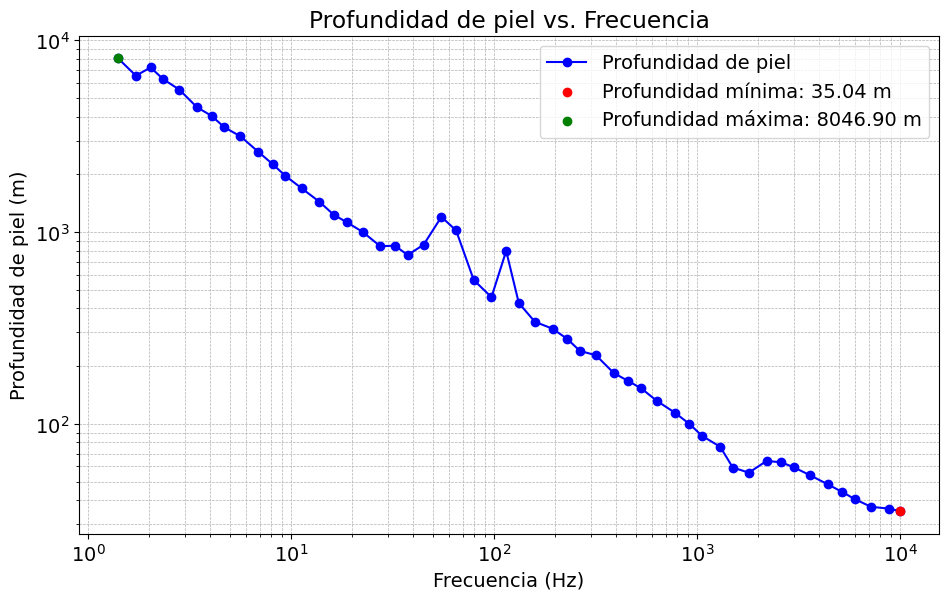

In [82]:
plt.figure(figsize=(10, 6))
plt.loglog(df['Frecuencias'], df['Profundidad de piel (m)'], marker='o', linestyle='-', color='b', label='Profundidad de piel')
plt.scatter(df.iloc[0]['Frecuencias'], d_max, color='r', label=f'Profundidad mínima: {d_max:.2f} m', zorder=5)
plt.scatter(df.iloc[-1]['Frecuencias'], d_min, color='g', label=f'Profundidad máxima: {d_min:.2f} m', zorder=5)
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Profundidad de piel (m)')
plt.title('Profundidad de piel vs. Frecuencia')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

#### **Datos a usar**

Anteriormente tenemos nuestros datos como un dataframe de 3 columnas, vamos a separarlos y crear el dobs que se usará en la inversión. 

In [17]:
#Extraemos los datos de las columnas del dataframe que tenemos anteriomente
frecuencias = df['Frecuencias'].values
rho_app = df['Resistividad aparente'].values
phase = df['Fase'].values        
#Reescribimos el dobs con el rango de datos que sí nos sirven
dobs = np.empty((0,))  
for r, p in zip(rho_app, phase):
    dobs = np.concatenate((dobs, [r, p]))

print("Datos observados:","\n" ,dobs, len(dobs), type(dobs)) #Imprimimos los datos, corroborando la cantidad 
                                                                  #Podemos corroborar la alternancia R,i con la sección anterior

Datos observados: 
 [ 48.517079    49.11335208  45.44390913  50.85006452  38.78612374
  49.18135888  38.79803451  46.58105411  39.93976159  46.64313477
  40.75303896  47.63667251  41.43711533  48.42831712  41.71666575
  49.84440886  40.83025461  52.60180405  35.65623994  58.88220294
  22.03218642  61.05446467  20.76703851  45.47517937  29.62554442
  31.31182069  31.35524789  41.35903169  36.1521635   40.64697051
  40.21318696  39.85339103  43.43725899  40.26182377  49.28182096
  39.09011726  50.57569529  38.99972587  52.16755091  40.13331982
  65.17461726  36.0320811   60.33408136  38.52759376  69.67963781
  32.54272071  75.40344363  34.04425681  72.85584541  32.75577375
  95.31531614  31.64728949 288.45629713   9.91781578  80.36488696
  32.80488627  99.2751226   29.36400414 267.28708871  14.34729604
 313.5494246   10.57504897 131.53706253  18.26476921  85.4659782
  34.69729721  92.78366648  12.4941087   77.37712575  10.81147072
  89.45519665  35.130505    94.25398743  32.92890727  97.

## Inversión de datos reales

### Inversión parámetrica 

In [19]:
frequencies = frecuencias
n_layer = 5
wire_map = maps.Wires(("sigma", n_layer), ("t", n_layer - 1))
sigma_map = maps.ExpMap(nP=n_layer) * wire_map.sigma
layer_map = maps.ExpMap(nP=n_layer - 1) * wire_map.t


model_mapping = maps.IdentityMap(nP=n_layer)

receivers_list = [
    nsem.receivers.PointNaturalSource(component="app_res"),
    nsem.receivers.PointNaturalSource(component="phase"),
]

source_list = []
for freq in frequencies:
    source_list.append(nsem.sources.Planewave(receivers_list, freq))

survey = nsem.survey.Survey(source_list)

simulation = nsem.simulation_1d.Simulation1DRecursive(
    survey=survey, 
    sigmaMap=sigma_map,
    thicknessesMap=layer_map,
)
app_rho = df['Resistividad aparente'].values
phase = df['Fase'].values
std = np.c_[abs(app_rho)*0.03, np.ones(len(phase))*2].flatten()
noise = np.c_[np.random.randn(app_rho.size)*0.03*abs(app_rho), np.random.randn(app_rho.size)*2].flatten()
dobs = np.c_[app_rho, phase].flatten()
data_object = data.Data(survey, dobs=dobs, standard_deviation=std)
starting_model = np.log(np.r_[np.ones(n_layer)*1./100, np.ones(n_layer-1)*1000])

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.02e+08  4.41e+04  0.00e+00  4.41e+04    1.17e+05      0              
   1  1.02e+08  2.14e+04  8.22e-05  2.98e+04    9.40e+03      0              
   2  1.02e+08  2.27e+04  6.71e-05  2.95e+04    1.76e+03      0              
   3  2.03e+07  2.13e+04  6.80e-05  2.27e+04    4.62e+04      2              
   4  2.03e+07  1.53e+04  1.71e-04  1.88e+04       nan   

ValueError: Axis limits cannot be NaN or Inf

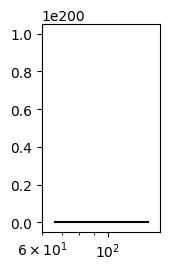

In [31]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
mesh = TensorMesh([n_layer])
# Define the regularization on the parameters related to resistivity
mesh_sigma = TensorMesh([mesh.h[0].size])
reg_sigma = regularization.Simple(mesh_sigma, alpha_s=0.01, alpha_x=0, mapping=wire_map.sigma)

# Define the regularization on the parameters related to layer thickness
mesh_t = TensorMesh([mesh.h[0].size - 1])
reg_t = regularization.Simple(mesh_t, alpha_s=0.01, alpha_x=0, mapping=wire_map.t)

# Combine to make regularization for the inversion problem
reg = reg_sigma + reg_t

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=30, maxIterCG=50)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# Define Inversion Directives
# ---------------------------
#
# Here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=5.0, coolingRate=3)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined in a list
directives_list = [
    update_sensitivity_weights,
    starting_beta,
    beta_schedule,
    target_misfit,
]

#####################################################################
# Running the Inversion
# ---------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)
import matplotlib.gridspec as gridspec
matplotlib.rcParams['font.size'] = 10
fig = plt.figure(figsize=(16*0.5, 5*0.5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
x_min = 1
x_max = 1000

plot_1d_layer_model(
    (layer_map * recovered_model)[::-1],
    (1./(sigma_map * recovered_model))[::-1],
    ax=ax0,
    color="k"
)
ax0.set_xlabel("Resistivity ($\Omega$m)")
ax0.set_xlim(1, 1e4)

ax = fig.add_subplot(gs[0, 2:])
ax.loglog(1./frequencies, dobs.reshape((len(frequencies), 2))[:,0], 'x', color='C0', label='Obs.-Amp.')
ax.loglog(1./frequencies, inv_prob.dpred.reshape((len(frequencies), 2))[:,0], color='C0', label='Pred.-Amp.')
ax_1 = ax.twinx()
ax_1.plot(1./frequencies, dobs.reshape((len(frequencies), 2))[:,1], 'x', color='C1', label='Obs.-Pha.')
ax_1.plot(1./frequencies, inv_prob.dpred.reshape((len(frequencies), 2))[:,1], color='C1', label='Pred.-Pha.')
ax.set_xlabel("Period (s)")
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel("Apparent resistivity ($\Omega$m)")
ax_1.set_ylabel("Phase ($\degree$)")
ax.legend(bbox_to_anchor=(1.1,1))
ax.legend(loc=3)
ax_1.legend(loc=4)
ax.set_ylim(1, 10000)
ax_1.set_ylim(0, 90)    
ax0.set_xlim(1, 10000)
plt.show()

### Inversión suavizada

In [18]:
dz = 30
n_layer = 23
z_factor = 1.2
layer_thicknesses_inv = dz*z_factor**np.arange(n_layer-1)[::-1]
print("El espesor total del modelo será:", layer_thicknesses_inv.sum(), "metros")

El espesor total del modelo será: 8130.921583686541 metros


In [71]:
dz = 30
n_layer = 23
z_factor = 1.2
layer_thicknesses_inv = dz*z_factor**np.arange(n_layer-1)[::-1]
frequencies=frecuencias
def run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1,
    use_irls=False,
    p_s=2,
    p_z=2
    
):
    mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.survey.Survey(source_list)

    sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses_inv,
    )
    # Define the data 
    data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)    
    
    # Initial model
    m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)
    
    # Reference model
    mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref)    
    
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

    # Define the regularization (model objective function)
    reg = regularization.Sparse(mesh_inv, alpha_s=alpha_s, alpha_x=alpha_z, reference_model=mref, mapping=maps.IdentityMap(mesh_inv))

    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach that employs the conjugate gradient solver.
    opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=maxIterCG)

    # Define the inverse problem
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

    #######################################################################
    # Define Inversion Directives
    # ---------------------------
    #
    # Here we define any directives that are carried out during the inversion. This
    # includes the cooling schedule for the trade-off parameter (beta), stopping
    # criteria for the inversion and saving inversion results at each iteration.
    #

    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)

    # Set the rate of reduction in trade-off parameter (beta) each time the
    # the inverse problem is solved. And set the number of Gauss-Newton iterations
    # for each trade-off paramter value.
    beta_schedule = directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=coolingRate)
    save_dictionary = directives.SaveOutputDictEveryIteration()
    save_dictionary.outDict = {}
    # Setting a stopping criteria for the inversion.
    target_misfit = directives.TargetMisfit(chifact=chi_factor)
    if use_irls:
        reg.norms = np.c_[p_s, p_z]
        # Reach target misfit for L2 solution, then use IRLS until model stops changing.
        IRLS = directives.Update_IRLS(max_irls_iterations=40, minGNiter=1, f_min_change=1e-5)

        # The directives are defined as a list.
        directives_list = [
            IRLS,
            starting_beta,
            save_dictionary,
        ]
    else:
        # The directives are defined as a list.
        directives_list = [
            starting_beta,
            beta_schedule,
            target_misfit,
            save_dictionary
        ]

    #####################################################################
    # Running the Inversion
    # ---------------------
    #
    # To define the inversion object, we need to define the inversion problem and
    # the set of directives. We can then run the inversion.
    #

    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)

    # Run the inversion
    recovered_model = inv.run(m0)    
    
    return recovered_model, save_dictionary.outDict
relative_error_rho = 0.42
floor_phase = 5
rho_app = df['Resistividad aparente'].values
phase = phase = df['Fase'].values  
standard_deviation = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten() 
# standard_deviation += dobs_error
rho_0 = 100
rho_ref = 100.
recovered_model, output_dict = run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=20,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1
)



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.12e+03  5.30e+02  0.00e+00  5.30e+02    4.43e+02      0              
   1  2.56e+03  1.13e+02  3.77e-03  1.23e+02    8.02e+01      0              
   2  1.28e+03  7.50e+01  6.72e-03  8.36e+01    2.33e+01      0   Skip BFGS  
   3  6.39e+02  6.30e+01  8.80e-03  6.87e+01    1.12e+01      0              
   4  3.20e+02  5.88e+01  1.20e-02  6.26e+01    8.02e+00      0              
   5  1.60e+02  5.68e+01  1.61e-02  5.94e+01    4.93e+00      0   Skip BFGS  
   6  7.99e+01  5.53e+01  2.36e

In [76]:
print(standard_deviation.mean())

28.49908774053218


In [72]:
target_misfit = dobs.size / 2.       
iterations = list(output_dict.keys())
n_iteration = len(iterations)
phi_ds = np.zeros(n_iteration)
phi_ms = np.zeros(n_iteration)
betas = np.zeros(n_iteration)
for ii, iteration in enumerate(iterations):
    phi_ds[ii] = output_dict[iteration]['phi_d']
    phi_ms[ii] = output_dict[iteration]['phi_m']
    betas[ii] = output_dict[iteration]['beta']

In [73]:
matplotlib.rcParams['font.size'] = 14
def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    plt.show()

In [77]:
from ipywidgets import interact, widgets
Q_iter = interact(
    tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration),
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=20, description='iteration', max=20, min=1), RadioButtons(description='s…

In [81]:
def plot_inverted_model_and_data(iteration):
    dpred = output_dict[iteration]['dpred']
    m = output_dict[iteration]['m']
    fig = plt.figure(figsize=(16, 5))
    gs = gridspec.GridSpec(1, 5, figure=fig)

    ax0 = fig.add_subplot(gs[0, 0])
    plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(m)))[::-1],
    ax=ax0,
    color="k",**{'linestyle':'-'},
    )
    # ax0.legend()
    ax0.set_xlabel("Resistividad ($\Omega$m)")
    ax0.set_ylabel("Profundidad (m)")
    #ax0.set_xlim(1, 10000)
    # ax0.set_xlim(1, 1e4)
    ax0.set_xlim(10,100000)

    ax = fig.add_subplot(gs[0, 2:])
    ax.loglog(1./frequencies, dobs.reshape((len(frequencies), 2))[:,0], 'x', color='C0', label='Obs.-AppRho.')
    ax.loglog(1./frequencies, dpred.reshape((len(frequencies), 2))[:,0], color='C0', label='Pred.-AppRho.')

    ax_1 = ax.twinx()
    ax_1.plot(1./frequencies, dobs.reshape((len(frequencies), 2))[:,1], 'x', color='C1', label='Obs.-Pha.')
    ax_1.plot(1./frequencies, dpred.reshape((len(frequencies), 2))[:,1], color='C1', label='Pred.-Pha.')
    ax.set_xlabel("Period (s)")
    ax.grid(True, which='both', alpha=0.5)
    ax.set_ylabel("Resistividad Aparente ($\Omega$m)")
    ax_1.set_ylabel("Fase ($\degree$)")
    # ax.legend(bbox_to_anchor=(1.1,1))
    ax.legend(loc=2)
    ax_1.legend(loc=1)
    ax.set_ylim(1, 10000)
    ax_1.set_ylim(0, 90)    
    ax0.set_xlim(1, 10000)
    plt.show()
interact(
    plot_inverted_model_and_data, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration)
)

interactive(children=(IntSlider(value=20, description='iteration', max=20, min=1), Output()), _dom_classes=('w…

<function __main__.plot_inverted_model_and_data(iteration)>

print(frequencies)

In [24]:
print(frequencies)

[1.000000e+04 8.800000e+03 7.200000e+03 6.000000e+03 5.200000e+03
 4.400000e+03 3.600000e+03 3.000000e+03 2.600000e+03 2.200000e+03
 1.800000e+03 1.500000e+03 1.300000e+03 1.058824e+03 9.176471e+02
 7.764706e+02 6.352941e+02 5.294118e+02 4.588235e+02 3.882353e+02
 3.176471e+02 2.647059e+02 2.294118e+02 1.941176e+02 1.588235e+02
 1.323529e+02 1.147059e+02 9.705882e+01 7.941176e+01 6.500000e+01
 5.500000e+01 4.500000e+01 3.750000e+01 3.250000e+01 2.750000e+01
 2.250000e+01 1.875000e+01 1.625000e+01 1.375000e+01 1.125000e+01
 9.375000e+00 8.125000e+00 6.875000e+00 5.625000e+00 4.687500e+00
 4.062500e+00 3.437500e+00 2.812500e+00 2.343750e+00 2.031250e+00
 1.718750e+00 1.406250e+00]
